In [1]:
pip install geopandas sqlalchemy psycopg2-binary

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 27.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 23.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 19.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.6 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
from sqlalchemy import create_engine

# Set up connection to PostGIS 
engine = create_engine("postgresql://postgres@localhost:5432/postgres")


In [7]:
import geopandas as gpd

parks_gdf = gpd.read_file("Downloads/green space access in nyc/data/Parks Properties_20250530.geojson")
neighborhoods_gdf = gpd.read_file("Downloads/green space access in nyc/data/2020 Neighborhood Tabulation Areas (NTAs)_20250530.geojson")

# Reproject to EPSG:4326 to match PostGIS expectations
parks_gdf = parks_gdf.to_crs(epsg=4326)
neighborhoods_gdf = neighborhoods_gdf.to_crs(epsg=4326)


In [9]:
parks_gdf.to_postgis(name='parks', con=engine, if_exists='replace', index=False)
neighborhoods_gdf.to_postgis(name='neighborhoods', con=engine, if_exists='replace', index=False)

print("✅ Data successfully loaded into PostGIS.")


ImportError: 'to_postgis()' requires geoalchemy2 package.

In [11]:
pip install geoalchemy2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 3.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [39]:
parks_gdf.to_postgis(name='parks', con=engine, if_exists='replace', index=False)
neighborhoods_gdf.to_postgis(name='neighborhoods', con=engine, if_exists='replace', index=False)

print("Data successfully loaded into PostGIS.")

Data successfully loaded into PostGIS.


In [17]:
import pandas as pd
from sqlalchemy import create_engine

engine = create_engine("postgresql://postgres@localhost:5432/postgres")

# Check columns in parks table
pd.read_sql("SELECT * FROM parks LIMIT 5;", engine)


,jurisdiction,mapped,zipcode,acres,location,nys_assembly,councildistrict,typecategory,us_congress,eapply,...,gisobjid,signname,address,permitparent,class,nys_senate,permitdistrict,borough,waterfront,geometry
0,DPR,False,10453,0.344,E. 181 St. bet. Walton Ave. and Jerome A,86,14,Playground,15,Walton Park,...,100003721,Walton Park,2115 WALTON AVENUE,X-05,PARK,33,X-05,X,false,0106000020E61000000100000001030000000100000007...
1,DPR,False,10453,0.436,E. 181 St. bet. Morris Ave. and Creston,86,14,Playground,15,Mabel Hampton Playground,...,100004216,Mabel Hampton Playground,2096-2116 Morris Ave.,X-05,PARK,33,X-05,X,false,0106000020E61000000100000001030000000100000008...
2,DPR,False,10453,0.06,Buchanan Pl. bet. Jerome Ave. and Davidso,86,14,Garden,13,Jardin De Las Rosas,...,100004340,Jardin De Las Rosas,15 BUCHANAN PLACE,X-05,PARK,33,X-05,X,false,0106000020E61000000100000001030000000100000005...
3,DPR,False,10453,0.15,E. 175th St. at Walton Ave.,77,14,Garden,15,Townsend Garden,...,100004037,Townsend Garden,1735 WALTON AVENUE,X-05,PARK,33,X-05,X,false,0106000020E61000000100000001030000000100000005...
4,DPR,True,10019,5.829,"W. 52 St. To W. 54 St., 11 Ave. To 12 Ave.",67,3,Playground,12,De Witt Clinton Park,...,100004485,De Witt Clinton Park,601 W 52 STREET,M-04,PARK,47,M-04,M,false,0106000020E61000000100000001030000000100000005...


In [37]:
import psycopg2

conn = psycopg2.connect(
    dbname="postgres",
    user="postgres",
    password="your_password",  # use "" if no password
    host="localhost",
    port="5432"
)

cursor = conn.cursor()

cursor.execute("""
DROP TABLE IF EXISTS park_buffers;
CREATE TABLE park_buffers AS
SELECT gisobjid, ST_Buffer(geometry::geography, 500)::geometry AS geom
FROM parks;
""")

cursor.execute("""
DROP TABLE IF EXISTS access_results;
CREATE TABLE access_results AS
SELECT n.*, 
       CASE WHEN ST_Intersects(n.geometry, b.geom) THEN TRUE ELSE FALSE END AS has_access
FROM neighborhoods n
LEFT JOIN park_buffers b
ON ST_Intersects(n.geometry, b.geom);
""")


conn.commit()
cursor.close()
conn.close()

print("Buffer and access analysis completed.")


Buffer and access analysis completed.


In [23]:
pd.read_sql("SELECT * FROM parks LIMIT 1;", engine).columns


Index(['jurisdiction', 'mapped', 'zipcode', 'acres', 'location',
       'nys_assembly', 'councildistrict', 'typecategory', 'us_congress',
       'eapply', 'parentid', 'gispropnum', 'retired', 'communityboard',
       'objectid', 'globalid', 'name311', 'department', 'pip_ratable',
       'subcategory', 'precinct', 'permit', 'acquisitiondate', 'omppropid',
       'gisobjid', 'signname', 'address', 'permitparent', 'class',
       'nys_senate', 'permitdistrict', 'borough', 'waterfront', 'geometry'],
      dtype='object')

In [31]:
import geopandas as gpd

# Load directly from PostGIS using GeoPandas
gdf = gpd.read_postgis(
    "SELECT * FROM access_results;",
    con=engine,
    geom_col="geometry"  # this is your spatial column name
)


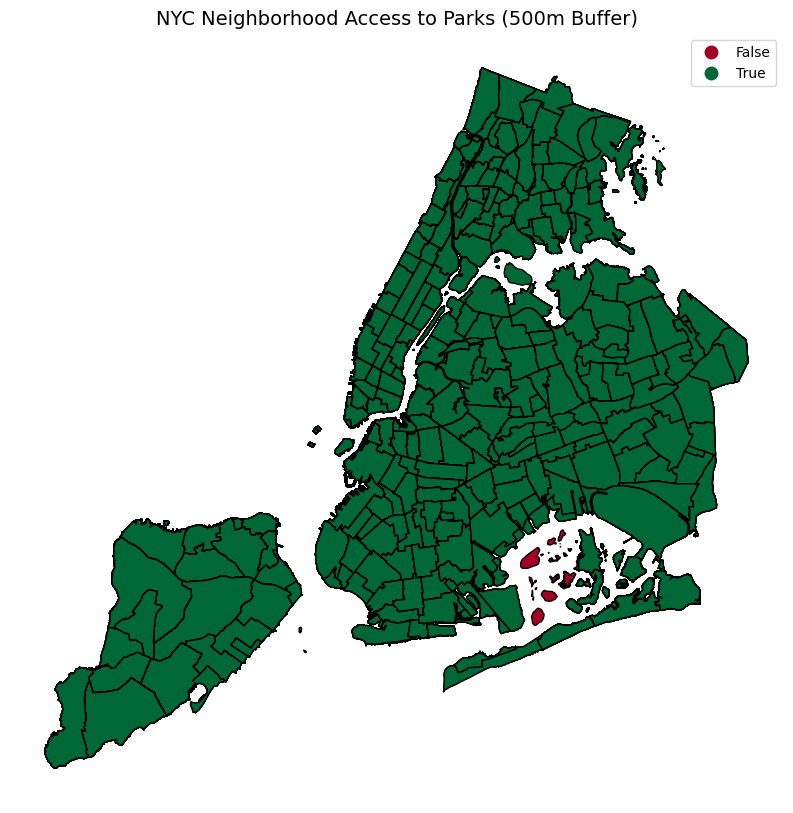

In [33]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 10))
gdf.plot(column="has_access", cmap="RdYlGn", legend=True, edgecolor="black", ax=ax)
plt.title("NYC Neighborhood Access to Parks (500m Buffer)", fontsize=14)
plt.axis("off")
plt.show()


In [35]:
# How many neighborhoods lack access?
summary = gdf["has_access"].value_counts(normalize=True) * 100
print("Neighborhood Access Summary:")
print(summary.rename({True: "Has Access", False: "No Access"}))


Neighborhood Access Summary:
has_access
Has Access    99.967272
No Access      0.032728
Name: proportion, dtype: float64


In [45]:
import pandas as pd

# Count parks per borough
borough_counts = parks_gdf["borough"].value_counts()
print("🏙️ Park Count by Borough:\n", borough_counts)



🏙️ Park Count by Borough:
 borough
B    626
Q    475
X    398
M    394
R    161
Name: count, dtype: int64


In [47]:
# Sum green space acreage per borough
borough_acreage = parks_gdf.groupby("borough")["acres"].sum().sort_values(ascending=False)
print("🌿 Total Park Acreage by Borough:\n", borough_acreage)


🌿 Total Park Acreage by Borough:
 borough
R    9.18183.352.683282751.9227.4630.4291.61.373.25...
M    5.8290.2230.5452.610.1440.2113.350.77415.5241....
B    2.30.3921.380.2130.1040.1061.561.0850.2060.032...
Q    0.8171.6571.7191.253.8671.5981.7492.7585.40.21...
X    0.3440.4360.060.150.6180.610.7140.70.3810.821....
Name: acres, dtype: object


In [ ]:
## Although Manhattan has many parks, Queens has the largest total green space area.

In [63]:
parks_gdf["typecategory"].value_counts()

typecategory
Triangle/Plaza                 354
Garden                         350
Neighborhood Park              292
Jointly Operated Playground    261
Playground                     250
Community Park                 113
Nature Area                     90
Recreational Field/Courts       75
Strip                           67
Undeveloped                     36
Mall                            34
Parkway                         29
Waterfront Facility             21
Buildings/Institutions          20
Managed Sites                   15
Flagship Park                   15
Historic House Park             12
Cemetery                        12
Lot                              5
Operations                       2
Retired N/A                      1
Name: count, dtype: int64

In [57]:
waterfront_ratio = parks_gdf["waterfront"].value_counts(normalize=True) * 100
print("🌊 Waterfront Park Ratio:\n", waterfront_ratio)


🌊 Waterfront Park Ratio:
 waterfront
false    91.378471
true      8.621529
Name: proportion, dtype: float64
